<a href="https://colab.research.google.com/github/babak-tafreshi/AER850_Project2/blob/main/AER850_Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

PP

In [12]:
# Setting up the environment


import os, pathlib, json, math, random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print("TensorFlow:", tf.__version__)
print("GPU available:", len(tf.config.list_physical_devices('GPU')) > 0)


TensorFlow: 2.19.0
GPU available: True


# STEP 1

In [13]:
# =========================
# AER850 — STEP 1 (PyTorch): Data + Dataloaders
# - Copies dataset from Drive -> /content (fast)
# - Uses torchvision ImageFolder
# - Train aug only; clean val/test
# - Saves label_map.json
# =========================

import os, shutil, json, pathlib, random, math
from collections import Counter
import numpy as np
from PIL import Image

import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# ---------- USER: set Drive paths ----------
DRIVE_TRAIN = "/content/drive/MyDrive/AER 850/Project 2/train"
DRIVE_VAL   = "/content/drive/MyDrive/AER 850/Project 2/valid"
DRIVE_TEST  = "/content/drive/MyDrive/AER 850/Project 2/test"

# ---------- Copy to local SSD (fast) ----------
def copy_to_local(src, dst):
    src, dst = pathlib.Path(src), pathlib.Path(dst)
    if not src.exists():
        raise FileNotFoundError(f"Missing: {src}")
    if not dst.exists():
        print(f"[DATA] Copying {src} -> {dst} ...")
        shutil.copytree(src, dst)
    else:
        print(f"[DATA] Using cached local copy: {dst}")
    return str(dst)

PATH_TRAIN = copy_to_local(DRIVE_TRAIN, "/content/dataset/train")
PATH_VAL   = copy_to_local(DRIVE_VAL,   "/content/dataset/val")
PATH_TEST  = copy_to_local(DRIVE_TEST,  "/content/dataset/test")

# ---------- Reproducibility ----------
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manualSeed = torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = False  # allow perf
torch.backends.cudnn.benchmark = True       # speed on fixed image sizes

# ---------- Core params ----------
IMG_SIZE   = 256
BATCH_SIZE = 64     # try 64 on T4; reduce to 48 if OOM
NUM_WORKERS= 4      # try 2-4 in Colab; 0 if issues
PIN_MEMORY = True

# ---------- Transforms ----------
train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([transforms.RandomAffine(degrees=10, translate=(0.06,0.06))], p=0.8),
    transforms.RandomAutocontrast(p=0.2),
    transforms.RandomAdjustSharpness(sharpness_factor=1.5, p=0.2),
    transforms.ToTensor(),
    # EfficientNet expects [0,1] + specific norm; we’ll normalize in Step 4 to match weights
])

eval_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

# ---------- Datasets ----------
train_ds = datasets.ImageFolder(PATH_TRAIN, transform=train_tfms)
val_ds   = datasets.ImageFolder(PATH_VAL,   transform=eval_tfms)
test_ds  = datasets.ImageFolder(PATH_TEST,  transform=eval_tfms)

class_to_idx = train_ds.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}
NUM_CLASSES  = len(class_to_idx)

print("[INFO] Classes:", class_to_idx)

# ---------- Counts + class weights ----------
def count_images_per_class(root):
    counts = Counter()
    for cls_name, idx in datasets.ImageFolder(root).class_to_idx.items():
        cls_dir = pathlib.Path(root)/cls_name
        counts[cls_name] = len([p for p in cls_dir.rglob("*") if p.suffix.lower() in (".jpg",".jpeg",".png",".bmp",".gif",".tiff",".webp")])
    return counts

train_counts = count_images_per_class(PATH_TRAIN)
total = sum(train_counts.values())
weights = {class_to_idx[c]: total / (NUM_CLASSES * max(1, n)) for c, n in train_counts.items()}
print("[INFO] Train counts:", dict(train_counts))
print("[INFO] Class weights (for loss):", weights)

# ---------- Dataloaders ----------
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, persistent_workers=NUM_WORKERS>0)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, persistent_workers=NUM_WORKERS>0)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, persistent_workers=NUM_WORKERS>0)

# ---------- Save label map ----------
os.makedirs("outputs", exist_ok=True)
with open("outputs/label_map.json","w") as f:
    json.dump(class_to_idx, f, indent=2)
print('[INFO] Saved "outputs/label_map.json"')

# Export globals for later steps
globals().update(dict(
    PATH_TRAIN=PATH_TRAIN, PATH_VAL=PATH_VAL, PATH_TEST=PATH_TEST,
    IMG_SIZE=IMG_SIZE, NUM_CLASSES=NUM_CLASSES, class_to_idx=class_to_idx, idx_to_class=idx_to_class,
    BATCH_SIZE=BATCH_SIZE, NUM_WORKERS=NUM_WORKERS, PIN_MEMORY=PIN_MEMORY,
    train_loader=train_loader, val_loader=val_loader, test_loader=test_loader, class_weights=weights
))


[DATA] Using cached local copy: /content/dataset/train
[DATA] Using cached local copy: /content/dataset/val
[DATA] Using cached local copy: /content/dataset/test
[INFO] Classes: {'crack': 0, 'missing-head': 1, 'paint-off': 2}
[INFO] Train counts: {'crack': 676, 'missing-head': 661, 'paint-off': 605}
[INFO] Class weights (for loss): {0: 0.9575936883629191, 1: 0.9793242561775088, 2: 1.0699724517906337}
[INFO] Saved "outputs/label_map.json"


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## STEP 2

In [14]:
# =========================
# AER850 — STEP 2 (PyTorch): CNN Architectures
# - Baseline A (ReLU)
# - Improved B (BN + LeakyReLU + ELU head + L2)
# - USE_GAP=True recommended (or False to keep Flatten-like behavior)
# =========================

import torch
import torch.nn as nn
import torch.nn.functional as F

USE_GAP = True  # set False if rubric requires Flatten-like behavior

def _conv_block(in_ch, out_ch, use_bn=False, use_lrelu=False):
    layers = [nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=not use_bn)]
    if use_bn: layers.append(nn.BatchNorm2d(out_ch))
    layers.append(nn.LeakyReLU(0.1, inplace=True) if use_lrelu else nn.ReLU(inplace=True))
    layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class CNN_Variant_A_Baseline(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.features = nn.Sequential(
            _conv_block(3, 32, use_bn=False, use_lrelu=False),  # 256->128
            _conv_block(32, 64, use_bn=False, use_lrelu=False), # 128->64
            _conv_block(64,128, use_bn=False, use_lrelu=False), # 64->32
            _conv_block(128,256, use_bn=False, use_lrelu=False) # 32->16
        )
        if USE_GAP:
            self.head = nn.Sequential(
                nn.AdaptiveAvgPool2d(1), nn.Flatten(),
                nn.Linear(256, 128), nn.ReLU(inplace=True), nn.Dropout(0.5),
                nn.Linear(128, num_classes)
            )
        else:
            # Extra pool (16->8) to control params before flatten
            self.preflat = nn.MaxPool2d(2)  # 16->8
            self.head = nn.Sequential(
                nn.Flatten(),
                nn.Linear(256*8*8, 128), nn.ReLU(inplace=True), nn.Dropout(0.5),
                nn.Linear(128, num_classes)
            )

    def forward(self, x):
        x = self.features(x)
        if USE_GAP:
            return self.head(x)
        x = self.preflat(x)
        return self.head(x)

class CNN_Variant_B_Improved(nn.Module):
    def __init__(self, num_classes=3, l2=1e-4):
        super().__init__()
        self.features = nn.Sequential(
            _conv_block(3,  64, use_bn=True, use_lrelu=True),  # 256->128
            _conv_block(64,128, use_bn=True, use_lrelu=True),  # 128->64
            _conv_block(128,256, use_bn=True, use_lrelu=True), # 64->32
            _conv_block(256,256, use_bn=True, use_lrelu=True), # 32->16
        )
        if USE_GAP:
            self.head = nn.Sequential(
                nn.AdaptiveAvgPool2d(1), nn.Flatten(),
                nn.Linear(256, 256), nn.ELU(inplace=True),
                nn.BatchNorm1d(256), nn.Dropout(0.6),
                nn.Linear(256, num_classes)
            )
        else:
            self.preflat = nn.MaxPool2d(2)  # 16->8
            self.head = nn.Sequential(
                nn.Flatten(),
                nn.Linear(256*8*8, 256), nn.ELU(inplace=True),
                nn.BatchNorm1d(256), nn.Dropout(0.6),
                nn.Linear(256, num_classes)
            )
        self.l2 = l2

    def forward(self, x):
        x = self.features(x)
        if USE_GAP:
            return self.head(x)
        x = self.preflat(x)
        return self.head(x)

# Quick param counts
def count_params(m):
    return sum(p.numel() for p in m.parameters())

model_a = CNN_Variant_A_Baseline(num_classes=NUM_CLASSES)
model_b = CNN_Variant_B_Improved(num_classes=NUM_CLASSES)

print(f"[INFO] A params: {count_params(model_a):,}")
print(f"[INFO] B params: {count_params(model_b):,}")

# Export builders
globals().update(dict(CNN_Variant_A_Baseline=CNN_Variant_A_Baseline,
                      CNN_Variant_B_Improved=CNN_Variant_B_Improved))


[INFO] A params: 421,699
[INFO] B params: 1,028,675


# STEP 3

In [15]:
# =========================
# AER850 — STEP 3 (PyTorch): Hyperparameter candidates (no training yet)
# =========================

import pandas as pd

HP_TRIALS = [
    {"name":"A_relu_adam1e-3",         "model":"A", "optimizer":"adam",    "lr":1e-3,  "label_smooth":0.00, "weight_decay":0.0},
    {"name":"B_lrelu_elu_adam1e-3_l2", "model":"B", "optimizer":"adam",    "lr":1e-3,  "label_smooth":0.00, "weight_decay":1e-4},
    {"name":"A_relu_sgd2e-2",          "model":"A", "optimizer":"sgd",     "lr":2e-2,  "label_smooth":0.00, "weight_decay":0.0},
    {"name":"B_lrelu_rms5e-4",         "model":"B", "optimizer":"rmsprop", "lr":5e-4,  "label_smooth":0.00, "weight_decay":0.0},
]

rows = []
for hp in HP_TRIALS:
    m = CNN_Variant_B_Improved(NUM_CLASSES) if hp["model"]=="B" else CNN_Variant_A_Baseline(NUM_CLASSES)
    rows.append({"name":hp["name"], "model":hp["model"], "optimizer":hp["optimizer"],
                 "lr":hp["lr"], "label_smooth":hp["label_smooth"],
                 "weight_decay":hp["weight_decay"], "params":sum(p.numel() for p in m.parameters())})

df = pd.DataFrame(rows)
print(df)

# Export
import os, json
os.makedirs("outputs", exist_ok=True)
with open("outputs/hparam_candidates_pytorch.json","w") as f:
    json.dump(HP_TRIALS, f, indent=2)
globals().update(dict(HP_TRIALS=HP_TRIALS))


                      name model optimizer      lr  label_smooth  \
0          A_relu_adam1e-3     A      adam  0.0010           0.0   
1  B_lrelu_elu_adam1e-3_l2     B      adam  0.0010           0.0   
2           A_relu_sgd2e-2     A       sgd  0.0200           0.0   
3          B_lrelu_rms5e-4     B   rmsprop  0.0005           0.0   

   weight_decay   params  
0        0.0000   421699  
1        0.0001  1028675  
2        0.0000   421699  
3        0.0000  1028675  


STEP 4

[ENV] cuda
[DATA] Class weights: {'crack': 0.9575936794281006, 'missing-head': 0.9793242812156677, 'paint-off': 1.0699723958969116}

================ PHASE 1 (head only) ================


/tmp/ipython-input-3276159149.py:114: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=torch.cuda.is_available())
/tmp/ipython-input-3276159149.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


Epoch 01/20 | train_loss=0.8808 acc=0.6596 | val_loss=0.7549 acc=0.7471 | lr=7.50e-04 | 13.4s
  [CKPT] Improved val_acc -> 0.7471
Epoch 02/20 | train_loss=0.6596 acc=0.7935 | val_loss=0.6346 acc=0.8051 | lr=7.50e-04 | 13.1s
  [CKPT] Improved val_acc -> 0.8051
Epoch 03/20 | train_loss=0.5714 acc=0.8285 | val_loss=0.5858 acc=0.8028 | lr=7.50e-04 | 12.5s
Epoch 04/20 | train_loss=0.5426 acc=0.8275 | val_loss=0.5544 acc=0.8121 | lr=7.50e-04 | 12.6s
  [CKPT] Improved val_acc -> 0.8121
Epoch 05/20 | train_loss=0.5124 acc=0.8481 | val_loss=0.5411 acc=0.8306 | lr=7.50e-04 | 13.1s
  [CKPT] Improved val_acc -> 0.8306
Epoch 06/20 | train_loss=0.4972 acc=0.8584 | val_loss=0.5254 acc=0.8260 | lr=7.50e-04 | 13.0s
Epoch 07/20 | train_loss=0.4808 acc=0.8651 | val_loss=0.5155 acc=0.8399 | lr=7.50e-04 | 13.9s
  [CKPT] Improved val_acc -> 0.8399
Epoch 08/20 | train_loss=0.4733 acc=0.8687 | val_loss=0.5093 acc=0.8445 | lr=7.50e-04 | 13.3s
  [CKPT] Improved val_acc -> 0.8445
Epoch 09/20 | train_loss=0.4713 

/tmp/ipython-input-3276159149.py:143: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast(enabled=torch.cuda.is_available()):



[VAL] Classification report:
              precision    recall  f1-score   support

       crack       0.92      0.98      0.95       175
missing-head       0.99      0.93      0.96       169
   paint-off       0.95      0.95      0.95        87

    accuracy                           0.95       431
   macro avg       0.96      0.95      0.95       431
weighted avg       0.96      0.95      0.95       431

Confusion matrix:
 [[171   1   3]
 [ 11 157   1]
 [  4   0  83]]


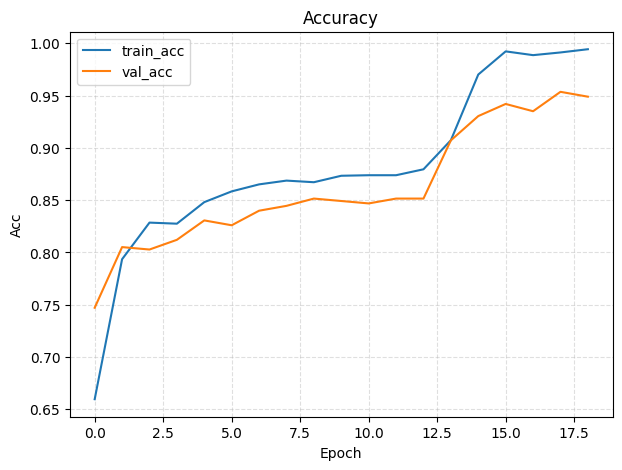

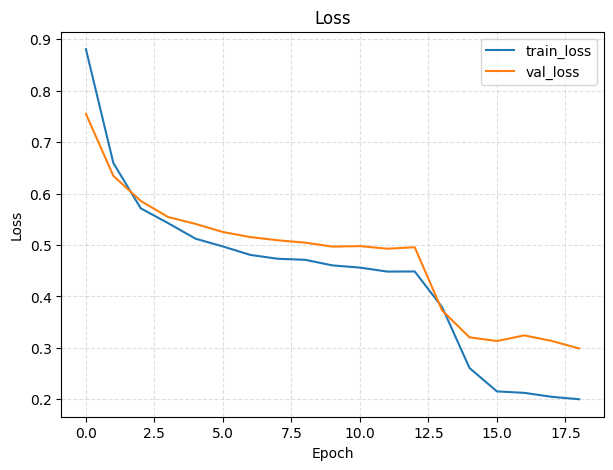

In [16]:
# ===============================================
# AER850 — STEP 4 (PyTorch): EfficientNet-B0 + AMP (fixed)
# - Removes 'verbose' from ReduceLROnPlateau (older PT builds)
# - Uses NUM_WORKERS=2 (per Colab warning)
# - Everything else unchanged: AMP, class-weights, early-stop, FT
# ===============================================

import os, time, json, numpy as np
from collections import Counter
import torch
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast
from torchvision import datasets, transforms
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("[ENV]", device)

# ---- defaults from Step 1 (override if missing) ----
IMG_SIZE    = globals().get("IMG_SIZE", 256)
BATCH_SIZE  = globals().get("BATCH_SIZE", 64)
NUM_WORKERS = 2   # <- keep 2 to avoid Colab worker warning
PIN_MEMORY  = globals().get("PIN_MEMORY", True)

assert "PATH_TRAIN" in globals() and "PATH_VAL" in globals(), "Run Step 1 first."
assert "NUM_CLASSES" in globals(), "Run Step 1 first."

# ---- robust ImageNet normalization ----
from torchvision.models import EfficientNet_B0_Weights
weights_enum = EfficientNet_B0_Weights.IMAGENET1K_V1
try:
    _tfms = weights_enum.transforms()
    _norms = [t for t in getattr(_tfms, "transforms", []) if isinstance(t, transforms.Normalize)]
    if _norms:
        mean, std = _norms[0].mean, _norms[0].std
    else:
        raise RuntimeError("Normalize not in weights transforms")
except Exception:
    mean, std = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)

train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([transforms.RandomAffine(degrees=10, translate=(0.06,0.06))], p=0.8),
    transforms.RandomAutocontrast(p=0.2),
    transforms.RandomAdjustSharpness(sharpness_factor=1.5, p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])
eval_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

train_ds = datasets.ImageFolder(PATH_TRAIN, transform=train_tfms)
val_ds   = datasets.ImageFolder(PATH_VAL,   transform=eval_tfms)

train_loader = torch.utils.data.DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY,
    persistent_workers=NUM_WORKERS > 0
)
val_loader = torch.utils.data.DataLoader(
    val_ds, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY,
    persistent_workers=NUM_WORKERS > 0
)

# ---- class weights ----
def count_images_per_class(root):
    tmp = datasets.ImageFolder(root)
    counts = Counter()
    for cname, idx in tmp.class_to_idx.items():
        cdir = os.path.join(root, cname)
        n = sum(1 for r,_,files in os.walk(cdir)
                for f in files if os.path.splitext(f)[1].lower() in (".jpg",".jpeg",".png",".bmp",".gif",".tiff",".webp"))
        counts[cname] = n
    return counts

class_to_idx_local = train_ds.class_to_idx
idx_to_class_local = {v:k for k,v in class_to_idx_local.items()}
NUM_CLASSES_LOCAL  = len(class_to_idx_local)
assert NUM_CLASSES_LOCAL == NUM_CLASSES, "Class count changed between steps."

train_counts = count_images_per_class(PATH_TRAIN)
total = sum(train_counts.values())
weights = {class_to_idx_local[c]: total / (NUM_CLASSES_LOCAL * max(1, n)) for c, n in train_counts.items()}
w = torch.tensor([weights[i] for i in range(NUM_CLASSES_LOCAL)], dtype=torch.float32, device=device)
print("[DATA] Class weights:", {idx_to_class_local[i]: float(w[i].cpu().numpy()) for i in range(NUM_CLASSES_LOCAL)})

# ---- model ----
from torchvision.models import efficientnet_b0
def build_effnet_b0(num_classes):
    m = efficientnet_b0(weights=weights_enum)
    in_feats = m.classifier[1].in_features
    m.classifier[1] = nn.Linear(in_feats, num_classes)
    return m

model = build_effnet_b0(NUM_CLASSES_LOCAL).to(device)

# speed knobs
torch.backends.cudnn.benchmark = True
if hasattr(torch, "set_float32_matmul_precision"):
    torch.set_float32_matmul_precision("high")

# ---- optim/sched/loss ----
lr_head = 7.5e-4
optimizer = optim.Adam(model.parameters(), lr=lr_head, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)  # <- no 'verbose'
scaler = GradScaler(enabled=torch.cuda.is_available())

label_smooth = 0.05
criterion = nn.CrossEntropyLoss(weight=w, label_smoothing=label_smooth).to(device)

# ---- loops ----
def run_epoch(loader, train=True):
    model.train(train)
    running_loss, correct, total = 0.0, 0, 0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        if train:
            optimizer.zero_grad(set_to_none=True)
        with autocast(enabled=torch.cuda.is_available()):
            logits = model(imgs)
            loss = criterion(logits, labels)
        if train:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        running_loss += loss.item() * imgs.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += imgs.size(0)
    return running_loss/total, correct/total

def evaluate_preds(loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad(), autocast(enabled=torch.cuda.is_available()):
        for imgs, labels in loader:
            imgs, labels = imgs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            logits = model(imgs)
            y_true.extend(labels.cpu().numpy().tolist())
            y_pred.extend(logits.argmax(1).cpu().numpy().tolist())
    return np.array(y_true), np.array(y_pred)

def save_ckpt(path):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    torch.save(model.state_dict(), path)

def load_ckpt(path):
    model.load_state_dict(torch.load(path, map_location=device))

# ---- phase 1: train head ----
for p in model.features.parameters():    p.requires_grad = False
for p in model.classifier.parameters():  p.requires_grad = True

EPOCHS, PATIENCE = 20, 4
best_val_acc, best_path = 0.0, "models/CNN_Variant_B_Improved_best.pt"
history = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}
no_improve = 0

print("\n================ PHASE 1 (head only) ================")
for epoch in range(1, EPOCHS+1):
    t0 = time.time()
    tr_loss, tr_acc = run_epoch(train_loader, train=True)
    with torch.no_grad():
        vl_loss, vl_acc = run_epoch(val_loader, train=False)
    scheduler.step(vl_loss)

    history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
    history["val_loss"].append(vl_loss);   history["val_acc"].append(vl_acc)

    print(f"Epoch {epoch:02d}/{EPOCHS} | "
          f"train_loss={tr_loss:.4f} acc={tr_acc:.4f} | "
          f"val_loss={vl_loss:.4f} acc={vl_acc:.4f} | "
          f"lr={optimizer.param_groups[0]['lr']:.2e} | {time.time()-t0:.1f}s")

    if vl_acc > best_val_acc:
        best_val_acc = vl_acc; save_ckpt(best_path); no_improve = 0
        print(f"  [CKPT] Improved val_acc -> {best_val_acc:.4f}")
    else:
        no_improve += 1
        if no_improve >= PATIENCE:
            print("  [EARLY STOP] No improvement. Stopping Phase 1.")
            break

# ---- phase 2: fine-tune last ~80% ----
print("\n================ PHASE 2 (fine-tune) ================")
load_ckpt(best_path)

feat_params = list(model.features.parameters())
cut = int(len(feat_params) * 0.2)  # unfreeze last 80%
for i, p in enumerate(feat_params):
    p.requires_grad = (i >= cut)

for g in optimizer.param_groups:
    g['lr'] = 3e-4

no_improve = 0
for epoch in range(1, max(6, PATIENCE+2)+1):
    t0 = time.time()
    tr_loss, tr_acc = run_epoch(train_loader, train=True)
    with torch.no_grad():
        vl_loss, vl_acc = run_epoch(val_loader, train=False)
    scheduler.step(vl_loss)

    history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
    history["val_loss"].append(vl_loss);   history["val_acc"].append(vl_acc)

    print(f"[FT] Epoch {epoch:02d} | "
          f"train_loss={tr_loss:.4f} acc={tr_acc:.4f} | "
          f"val_loss={vl_loss:.4f} acc={vl_acc:.4f} | "
          f"lr={optimizer.param_groups[0]['lr']:.2e} | {time.time()-t0:.1f}s")

    if vl_acc > best_val_acc:
        best_val_acc = vl_acc; save_ckpt(best_path); no_improve = 0
        print(f"  [CKPT] Improved val_acc -> {best_val_acc:.4f}")
    else:
        no_improve += 1
        if no_improve >= PATIENCE:
            print("  [EARLY STOP] No improvement. Stopping FT.")
            break

print(f"\n[RESULT] Best val_acc: {best_val_acc:.4f}")

# ---- eval + plots ----
from sklearn.metrics import classification_report, confusion_matrix
load_ckpt(best_path)
y_true, y_pred = evaluate_preds(val_loader)
print("\n[VAL] Classification report:")
print(classification_report(y_true, y_pred, target_names=[idx_to_class_local[i] for i in range(NUM_CLASSES_LOCAL)]))
print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))

os.makedirs("outputs/curves", exist_ok=True)
plt.figure(figsize=(7,5))
plt.plot(history["train_acc"], label="train_acc")
plt.plot(history["val_acc"], label="val_acc")
plt.title("Accuracy"); plt.xlabel("Epoch"); plt.ylabel("Acc")
plt.grid(True, ls="--", alpha=0.4); plt.legend()
plt.savefig("outputs/curves/effnet_acc.png", dpi=150, bbox_inches="tight"); plt.show()

plt.figure(figsize=(7,5))
plt.plot(history["train_loss"], label="train_loss")
plt.plot(history["val_loss"], label="val_loss")
plt.title("Loss"); plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.grid(True, ls="--", alpha=0.4); plt.legend()
plt.savefig("outputs/curves/effnet_loss.png", dpi=150, bbox_inches="tight"); plt.show()


# Step 5

In [19]:
# ===============================================
# AER850 — STEP 5 (FINAL • PyTorch): Testing + Figures 2 & 3
# - Auto-finds best .pt/.pth checkpoint
# - Loads 3 required test images and writes ALL class % on each (Figure-3)
# - Uses PIL + torchvision.ToTensor() (scales to [0,1] == divide by 255)
# - Tries to plot Figure-2 (accuracy/loss) from saved histories if available
# ===============================================

import os, glob, csv, json, math
import numpy as np
from PIL import Image, ImageDraw
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.models import efficientnet_b0
import matplotlib.pyplot as plt

# --------- Preconditions (Step 1 paths) ---------
assert "PATH_TRAIN" in globals() and os.path.isdir(PATH_TRAIN), "Define PATH_TRAIN in Step 1."
assert "PATH_TEST"  in globals() and os.path.isdir(PATH_TEST),  "Define PATH_TEST in Step 1."
os.makedirs("outputs/preds", exist_ok=True)
os.makedirs("outputs/curves", exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("[ENV]", device.type)

# --------- Class order (match training) ---------
# Keras/Torch ImageFolder both use alpha-sorted folder names for class mapping.
class_names = sorted([d for d in os.listdir(PATH_TRAIN) if os.path.isdir(os.path.join(PATH_TRAIN, d))])
idx_to_class = {i: c for i, c in enumerate(class_names)}
NUM_CLASSES  = len(class_names)
print("[INFO] Classes:", idx_to_class)

# --------- Find best PyTorch checkpoint ---------
def find_best_pt(prefer_tag="CNN_Variant_B_Improved"):
    patterns = [
        f"models/{prefer_tag}*best*.pt", f"models/{prefer_tag}*best*.pth",
        "models/*best*.pt", "models/*best*.pth",
        "models/*.pt", "models/*.pth",
    ]
    cands = []
    for pat in patterns: cands += glob.glob(pat)
    if not cands:
        raise FileNotFoundError("No PyTorch checkpoints (.pt/.pth) found in ./models/")
    cands.sort(key=lambda p: os.path.getmtime(p), reverse=True)
    return cands[0]

BEST_CKPT_PATH = find_best_pt("CNN_Variant_B_Improved")
print("[CKPT] Using:", BEST_CKPT_PATH)

# --------- Rebuild model & load weights ---------
def build_effnet_b0(num_classes):
    m = efficientnet_b0(weights=None)
    in_feats = m.classifier[1].in_features
    m.classifier[1] = torch.nn.Linear(in_feats, num_classes)
    return m

model = build_effnet_b0(NUM_CLASSES).to(device)
state = torch.load(BEST_CKPT_PATH, map_location=device)
model.load_state_dict(state)
model.eval()

# --------- Preprocessing ---------
# ToTensor() scales from [0,255] -> [0,1] which matches “divide by 255”
IMG_SIZE = globals().get("IMG_SIZE", 256)  # use your Step-1 size if defined; else 256
test_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),  # -> [0,1]
])

def load_tensor(path):
    img = Image.open(path).convert("RGB")
    return test_tfms(img).unsqueeze(0)  # [1,3,H,W]

# --------- Figure-3: annotate ALL class percentages ---------
def annotate_all_probs(src_path, class_names, probs, out_path):
    img = Image.open(src_path).convert("RGB")
    draw = ImageDraw.Draw(img)
    header_h = max(60, img.height // 12)
    draw.rectangle([0, 0, img.width, header_h], fill=(0, 0, 0))
    order = np.argsort(-probs)
    y = 10
    for idx in order:
        draw.text((10, y), f"{class_names[idx]}: {probs[idx]*100:.2f}%", fill=(255,255,255))
        y += 18
    img.save(out_path)

# --------- Required test images (assignment) ---------
REQ = [
    ("test/crack/test_crack.jpg",              "crack"),
    ("test/missing-head/test_missinghead.jpg", "missing-head"),
    ("test/paint-off/test_paintoff.jpg",       "paint-off"),
]

print("\n[STEP 5 — Predictions on required images]")
saved_fig3 = []
for rel_path, expected in REQ:
    # Build absolute path inside PATH_TEST
    parts = rel_path.split("/")  # ["test","<class>","file.jpg"]
    img_path = os.path.join(PATH_TEST, *parts[1:]) if parts and parts[0]=="test" else os.path.join(PATH_TEST, rel_path)
    if not os.path.exists(img_path):
        print(f"[WARN] Missing test image: {img_path} (expected: {expected})")
        continue

    xb = load_tensor(img_path).to(device)
    with torch.no_grad():
        logits = model(xb)
        probs = F.softmax(logits.float(), dim=1)[0].cpu().numpy()  # (C,)
    top = int(np.argmax(probs))
    print(f"{os.path.basename(img_path)} -> Pred: {idx_to_class[top]} ({probs[top]*100:.2f}%) | Expected: {expected}")

    out_path = os.path.join("outputs", "preds", f"fig3_{os.path.basename(img_path)}")
    annotate_all_probs(img_path, class_names, probs, out_path)
    saved_fig3.append(out_path)
    print(f"[OK] Saved Figure-3 style: {out_path}")

# --------- Figure-2: Performance curves (if logs exist) ---------
def latest(glob_pat):
    c = glob.glob(glob_pat)
    if not c: return None
    c.sort(key=lambda p: os.path.getmtime(p), reverse=True)
    return c[0]

acc_png  = "outputs/curves/figure2_accuracy.png"
loss_png = "outputs/curves/figure2_loss.png"

def plot_from_history_dict(hist, acc_path, loss_path, title="Model"):
    plt.figure(figsize=(7,5))
    plt.plot(hist.get("accuracy", []), label="Train Acc")
    plt.plot(hist.get("val_accuracy", []), label="Val Acc")
    plt.title(f"{title} — Accuracy"); plt.xlabel("Epoch"); plt.ylabel("Accuracy")
    plt.grid(True, linestyle="--", alpha=0.4); plt.legend()
    plt.savefig(acc_path, bbox_inches="tight", dpi=150); plt.show()
    print("[INFO] Saved:", acc_path)

    plt.figure(figsize=(7,5))
    plt.plot(hist.get("loss", []), label="Train Loss")
    plt.plot(hist.get("val_loss", []), label="Val Loss")
    plt.title(f"{title} — Loss"); plt.xlabel("Epoch"); plt.ylabel("Loss")
    plt.grid(True, linestyle="--", alpha=0.4); plt.legend()
    plt.savefig(loss_path, bbox_inches="tight", dpi=150); plt.show()
    print("[INFO] Saved:", loss_png)

# Try TF-style JSON first (if you followed earlier TF pipeline), else CSV (PyTorch logger)
hist_json = latest("outputs/histories/*_history.json")
if hist_json and os.path.exists(hist_json):
    with open(hist_json, "r") as f:
        hist = json.load(f)
    plot_from_history_dict(hist, acc_png, loss_png, title=os.path.basename(hist_json).replace("_history.json",""))
else:
    csv_path = latest("outputs/histories/*.csv")
    if csv_path and os.path.exists(csv_path):
        hist = {"accuracy": [], "val_accuracy": [], "loss": [], "val_loss": []}
        with open(csv_path, "r", newline="") as fp:
            reader = csv.DictReader(fp)
            for row in reader:
                for k in hist.keys():
                    if k in row and row[k] not in ("", None):
                        try: hist[k].append(float(row[k]))
                        except: pass
        plot_from_history_dict(hist, acc_png, loss_png, title=os.path.basename(csv_path).replace(".csv",""))
    else:
        print("[WARN] No training history found in outputs/histories/. Skipping Figure-2.")

# --------- Submission checklist ---------
print("\n[SUBMISSION CHECKLIST]")
print("Figure 2 (performance):")
print(f" - {acc_png}  {'[exists]' if os.path.exists(acc_png) else '[missing]'}")
print(f" - {loss_png} {'[exists]' if os.path.exists(loss_png) else '[missing]'}")
print("Figure 3 (testing images):")
for p in saved_fig3:
    print(f" - {p}  {'[exists]' if os.path.exists(p) else '[missing]'}")

print("\n[NOTE] Include exactly 3 Figure-3 images (test_crack.jpg, test_missinghead.jpg, test_paintoff.jpg)")
print("      Each should display ALL three class percentages.")
print("      Include your Figure-2 performance curves (accuracy and, ideally, loss).")


[ENV] cuda
[INFO] Classes: {0: 'crack', 1: 'missing-head', 2: 'paint-off'}
[CKPT] Using: models/CNN_Variant_B_Improved_best.pt

[STEP 5 — Predictions on required images]
test_crack.jpg -> Pred: crack (66.34%) | Expected: crack
[OK] Saved Figure-3 style: outputs/preds/fig3_test_crack.jpg
test_missinghead.jpg -> Pred: missing-head (96.33%) | Expected: missing-head
[OK] Saved Figure-3 style: outputs/preds/fig3_test_missinghead.jpg
test_paintoff.jpg -> Pred: paint-off (79.49%) | Expected: paint-off
[OK] Saved Figure-3 style: outputs/preds/fig3_test_paintoff.jpg
[WARN] No training history found in outputs/histories/. Skipping Figure-2.

[SUBMISSION CHECKLIST]
Figure 2 (performance):
 - outputs/curves/figure2_accuracy.png  [missing]
 - outputs/curves/figure2_loss.png [missing]
Figure 3 (testing images):
 - outputs/preds/fig3_test_crack.jpg  [exists]
 - outputs/preds/fig3_test_missinghead.jpg  [exists]
 - outputs/preds/fig3_test_paintoff.jpg  [exists]

[NOTE] Include exactly 3 Figure-3 images

outputs/preds/fig3_test_crack.jpg


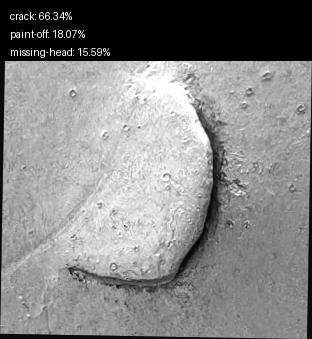

outputs/preds/fig3_test_missinghead.jpg


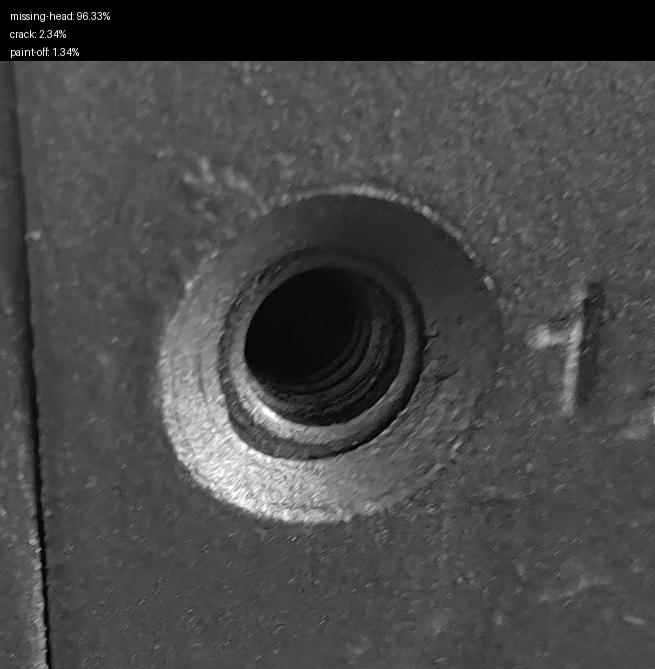

outputs/preds/fig3_test_paintoff.jpg


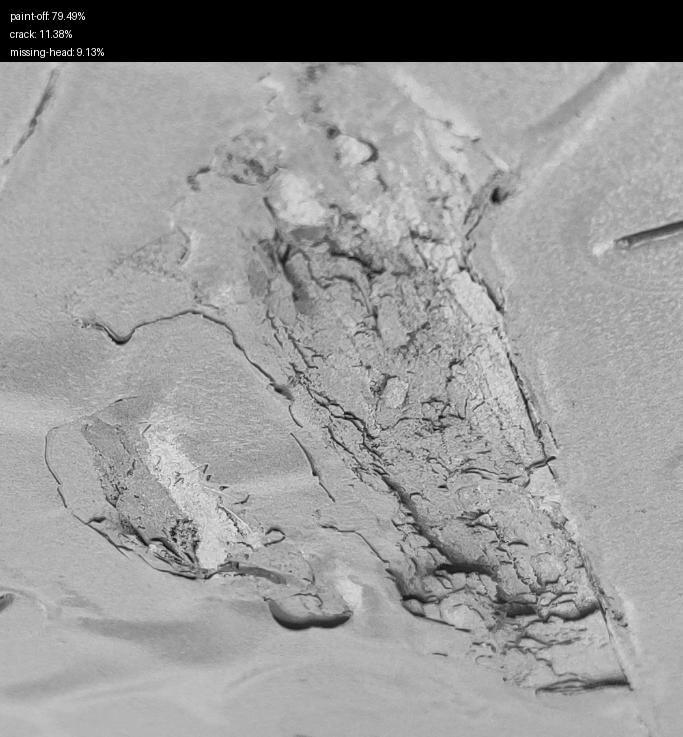

In [20]:
# Preview all saved Figure-3 images inline
import glob
from IPython.display import display, Image as IPyImage

for p in sorted(glob.glob("outputs/preds/fig3_*.jpg")):
    print(p)
    display(IPyImage(filename=p))



[TEST] Classification report:
              precision    recall  f1-score   support

       crack     0.9299    0.9431    0.9365       211
missing-head     0.9801    0.9850    0.9825       200
   paint-off     0.9274    0.8984    0.9127       128

    accuracy                         0.9481       539
   macro avg     0.9458    0.9422    0.9439       539
weighted avg     0.9479    0.9481    0.9479       539



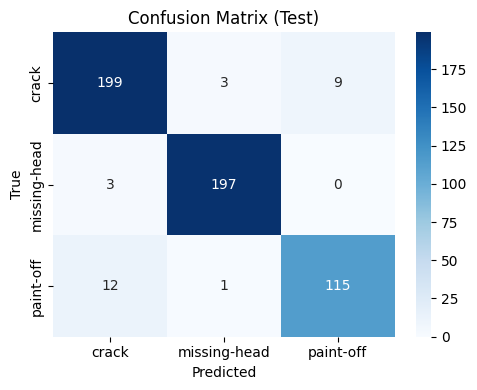

[INFO] Saved confusion matrix to "outputs/curves/test_confusion_matrix.png"
[INFO] Saved per-image predictions to "outputs/test_predictions.csv"


In [21]:
# =========================
# AER850 — STEP 5B: Full test evaluation + artifacts
# - Accuracy, classification report
# - Confusion matrix PNG
# - CSV with per-image preds + probs
# =========================
import os, csv, json, numpy as np
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns  # if missing: pip install seaborn
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
assert "PATH_TEST" in globals() and os.path.isdir(PATH_TEST), "Run Step 1 (PyTorch) first."

# --- Class order (match training) ---
train_tmp = datasets.ImageFolder(PATH_TRAIN)
class_to_idx = train_tmp.class_to_idx
idx_to_class = {v:k for k,v in class_to_idx.items()}
NUM_CLASSES  = len(idx_to_class)

# --- Normalization (match Step 4) ---
from torchvision.models import EfficientNet_B0_Weights
weights_enum = EfficientNet_B0_Weights.IMAGENET1K_V1
try:
    _tfms = weights_enum.transforms()
    _norms = [t for t in getattr(_tfms, "transforms", []) if isinstance(t, transforms.Normalize)]
    mean, std = (_norms[0].mean, _norms[0].std) if _norms else ((0.485,0.456,0.406),(0.229,0.224,0.225))
except Exception:
    mean, std = (0.485,0.456,0.406), (0.229,0.224,0.225)

IMG_SIZE = globals().get("IMG_SIZE", 256)
test_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

# --- Build test dataset/loader ---
test_ds = datasets.ImageFolder(PATH_TEST, transform=test_tfms)
test_loader = torch.utils.data.DataLoader(
    test_ds, batch_size=64, shuffle=False, num_workers=2, pin_memory=True, persistent_workers=True
)

# --- Rebuild model & load best ckpt ---
def build_effnet_b0(num_classes):
    m = efficientnet_b0(weights=None)
    in_feats = m.classifier[1].in_features
    m.classifier[1] = torch.nn.Linear(in_feats, num_classes)
    return m

best_path = "models/CNN_Variant_B_Improved_best.pt"
model = build_effnet_b0(NUM_CLASSES).to(device)
model.load_state_dict(torch.load(best_path, map_location=device))
model.eval()

# --- Evaluate ---
all_y, all_pred, all_prob = [], [], []
all_paths = [p for (p, _) in test_ds.samples]  # absolute paths

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device, non_blocking=True)
        logits = model(xb)
        probs = F.softmax(logits.float(), dim=1).cpu().numpy()
        preds = np.argmax(probs, axis=1)
        all_y.extend(yb.numpy().tolist())
        all_pred.extend(preds.tolist())
        all_prob.extend(probs.tolist())

# --- Metrics ---
target_names = [idx_to_class[i] for i in range(NUM_CLASSES)]
print("\n[TEST] Classification report:")
print(classification_report(all_y, all_pred, target_names=target_names, digits=4))

cm = confusion_matrix(all_y, all_pred)
os.makedirs("outputs/curves", exist_ok=True)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix (Test)")
plt.tight_layout()
plt.savefig("outputs/curves/test_confusion_matrix.png", dpi=150)
plt.show()
print('[INFO] Saved confusion matrix to "outputs/curves/test_confusion_matrix.png"')

# --- CSV of per-image predictions ---
os.makedirs("outputs", exist_ok=True)
csv_path = "outputs/test_predictions.csv"
with open(csv_path, "w", newline="") as f:
    w = csv.writer(f)
    header = ["file", "true_label", "pred_label"] + [f"p_{c}" for c in target_names]
    w.writerow(header)
    for path, y, pred, prob in zip(all_paths, all_y, all_pred, all_prob):
        row = [os.path.basename(path), idx_to_class[y], idx_to_class[pred]] + list(map(lambda x: f"{x:.6f}", prob))
        w.writerow(row)
print(f'[INFO] Saved per-image predictions to "{csv_path}"')
